### Set Parameters

In [1]:
pf_id = 2 #problem formulation id; should match file name
n_scenarios = pow(2, 10) # Ideally a power of 2 > 1000 ... 2^10 = 1024

### Run Model for Open Exploration

##### Define a nothing policy (necessary for the code to run)

In [2]:
# don't @ me it has to be set up this way to work
from ema_workbench import Policy
policies = [Policy('policy 0', **{'0_RfR 0':0,
                                  '0_RfR 1':0,
                                  '0_RfR 2':0,
                                  'A.1_DikeIncrease 0':0,
                                  'A.1_DikeIncrease 1':0,
                                  'A.1_DikeIncrease 2':0,
                                  '1_RfR 0':0,
                                  '1_RfR 1':0,
                                  '1_RfR 2':0,
                                  'A.2_DikeIncrease 0':0,
                                  'A.2_DikeIncrease 1':0,
                                  'A.2_DikeIncrease 2':0,
                                  '2_RfR 0':0,
                                  '2_RfR 1':0,
                                  '2_RfR 2':0,
                                  'A.3_DikeIncrease 0':0,
                                  'A.3_DikeIncrease 1':0,
                                  'A.3_DikeIncrease 2':0,
                                  '3_RfR 0':0,
                                  '3_RfR 1':0,
                                  '3_RfR 2':0,
                                  'A.4_DikeIncrease 0':0,
                                  'A.4_DikeIncrease 1':0,
                                  'A.4_DikeIncrease 2':0,
                                  '4_RfR 0':0,
                                  '4_RfR 1':0,
                                  '4_RfR 2':0,
                                  'A.5_DikeIncrease 0':0,
                                  'A.5_DikeIncrease 1':0,
                                  'A.5_DikeIncrease 2':0,
                                  'EWS_DaysToThreat':0
                                  })]

##### Import packages


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

##### Import things and set up model (with the selected problem formulation)


In [4]:
from ema_workbench.util import ema_logging
from problem_formulation import get_model_for_problem_formulation

ema_logging.log_to_stderr(ema_logging.INFO)

dike_model, planning_steps = get_model_for_problem_formulation(pf_id) #changes for each file

##### Define uncertainties and levers

In [5]:
import copy
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

##### Run the model with the defined number of scenarios and the nothing policy

In [6]:
from ema_workbench import (ema_logging, MultiprocessingEvaluator, Samplers)
ema_logging.log_to_stderr(ema_logging.INFO)
 
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies, uncertainty_sampling=Samplers.SOBOL)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 5000 scenarios * 1 policies * 1 model(s) = 5000 experiments
  0%|                                      | 1/5000 [00:16<23:18:13, 16.78s/it]Traceback (most recent call last):
  File "C:\Users\rhys_\anaconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 246, in _store_outcomes
    self.results[outcome][case_id,] = outcome_res
KeyError: 'Dike Investment Costs'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rhys_\anaconda3\lib\site-packages\ema_workbench\em_framework\ema_multiprocessing.py", line 253, in run
    self.callback(*result.get())
  File "C:\Users\rhys_\anaconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 281, in __call__
    self._store_outcomes(experiment.experiment_id, outcomes)
  File "C:\Users\rhys_\anaconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 260, in _s

##### Define experiments and outcome; print names of the outcomes

In [7]:
experiments, outcomes = results
print(outcomes.keys())

dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths'])


### Save Results

In [8]:
from ema_workbench import save_results

save_results(results, './output/open_exploration/Open_Exploration_id_%s.tar.gz'%pf_id)

[MainProcess/INFO] results saved successfully to C:\Users\rhys_\OneDrive - Maastricht University\Documents\GitHub\MBDM\final assignment\output\open_exploration\Open_Exploration_id_2.tar.gz


In [9]:
experiments.to_csv('./output/open_exploration/Open_Exploration_id_%s_exp.csv'%pf_id, index=False)
pd.DataFrame.from_dict(outcomes).to_csv('./output/open_exploration/Open_Exploration_id_%s_out.csv'%pf_id, index=False)

### Visualization

##### Import stuff

In [2]:
from ema_workbench.analysis import prim, dimensional_stacking, feature_scoring
from ema_workbench import load_results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

##### Load in previously saved results; can visualize without rerunning the whole notebook

In [3]:
results = load_results('./output/open_exploration/Open_Exploration_id_%s.tar.gz'%pf_id)
experiments, outcomes = results

##### As a failsafe, drop NaN outcomes by converting to pandas DataFrame

In [4]:
outcomes_pd = pd.DataFrame.from_dict(outcomes)
outcomes_pd.dropna(inplace=True)

##### Convert outcomes back into array dict

In [5]:
outcomes_nonan = outcomes_pd.to_dict('list')

for outcome in outcomes_nonan.keys():
    outcomes_nonan[outcome] = np.array(outcomes_nonan[outcome])

outcomes = outcomes_nonan

##### Drop corresponding runs from experiments

In [6]:
experiments.drop(list(set(experiments.index) - set(outcomes_pd.index)), inplace=True)

## Subspace Partitioning

This is where the names of each outcome will need to be fed into the visualizations to get reasonable outputs, ignore this for now or change the names yourself.

#### Outcome: All Costs

##### Define x, y, and threshold

In [15]:
x = experiments
data = outcomes[list(outcomes.keys())[1]] #outcomes["Dike Investment Costs"]
y = data <  np.percentile(data, 10) # 10 percent of worst outcomes

print(outcomes.keys())

dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths'])


##### Tradeoff density and coverage

In [16]:
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()
box1.show_tradeoff()
plt.show()

AssertionError: 

##### Dimensional stacking

In [9]:
dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3)
plt.show()

NameError: name 'y' is not defined

#### Outcome: Expected Number of Deaths

##### Define x, y, and threshold

In [10]:
x = experiments
data = outcomes["Expected Number of Deaths"]
y = data <  np.percentile(data, 10) # 10 percent of worst outcomes

##### Tradeoff density and coverage

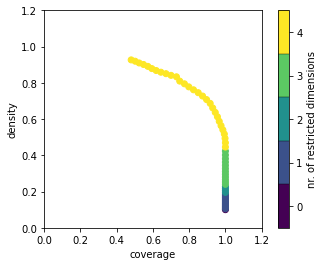

In [11]:
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()
box1.show_tradeoff()
plt.show()

##### Dimensional stacking


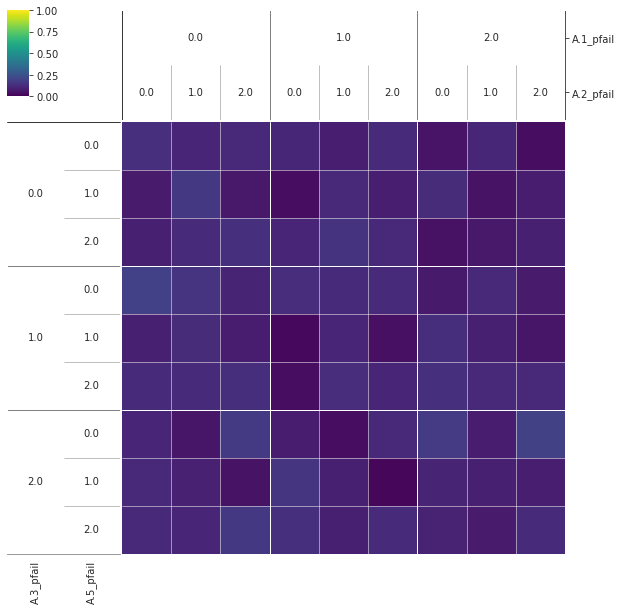

In [12]:
dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3)
plt.show()

### Sensitivity Analysis

### Feature Scoring

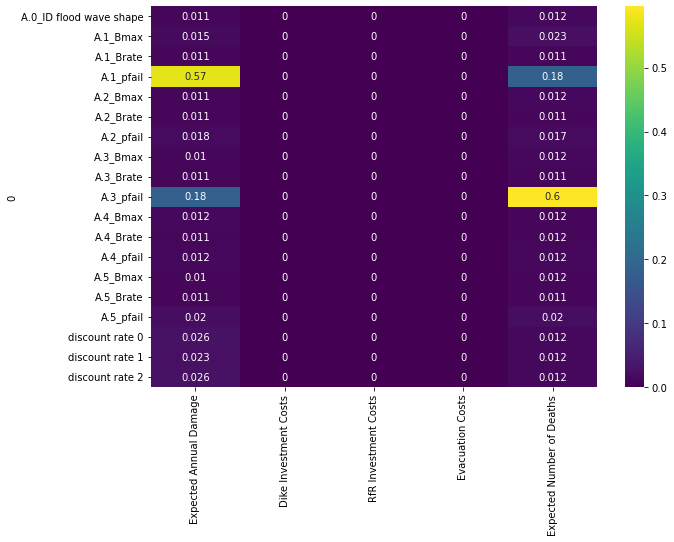

In [13]:
x = experiments.loc[:,['A.0_ID flood wave shape', 'A.1_pfail', 'A.2_pfail', 'A.3_pfail', 'A.4_pfail', 'A.5_pfail', 'A.1_Bmax', 'A.2_Bmax', 'A.3_Bmax', 'A.4_Bmax', 'A.5_Bmax',  'A.1_Brate', 'A.2_Brate', 'A.3_Brate', 'A.4_Brate', 'A.5_Brate', 'discount rate 0', 'discount rate 1', 'discount rate 2']]
y = outcomes

plt.figure(figsize = (10,7))

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True, )

plt.show()